In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#sequence
text = ("Next character prediction is a fundamental task in the field of natural language processing (NLP) "
        "that involves predicting the next character in a sequence of text based on the characters that precede it. "
        "This task is essential for various applications, including text auto-completion, spell checking, and even "
        "in the development of sophisticated AI models capable of generating human-like text.\n\n"
        "At its core, next character prediction relies on statistical models or deep learning algorithms to analyze "
        "a given sequence of text and predict which character is most likely to follow. These predictions are based "
        "on patterns and relationships learned from large datasets of text during the training phase of the model.\n\n"
        "One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks "
        "(RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly "
        "well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters "
        "to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember "
        "long-term dependencies, making them even more effective for next character prediction tasks.\n\n"
        "Training a model for next character prediction involves feeding it large amounts of text data, allowing it to "
        "learn the probability of each character's appearance following a sequence of characters. During this training "
        "process, the model adjusts its parameters to minimize the difference between its predictions and the actual "
        "outcomes, thus improving its predictive accuracy over time.\n\n"
        "Once trained, the model can be used to predict the next character in a given piece of text by considering the "
        "sequence of characters that precede it. This can enhance user experience in text editing software, improve "
        "efficiency in coding environments with auto-completion features, and enable more natural interactions with "
        "AI-based chatbots and virtual assistants.\n\n"
        "In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP "
        "applications, making text-based interactions more efficient, accurate, and human-like. Through the use of "
        "advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening "
        "new possibilities for the future of text-based technology.")

#Character-level encoding
chars = sorted(list(set(text)))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# onvert text to numerical data
encoded_text = [char_to_idx[c] for c in text]

#####Dataset class
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        self.data = [text[i: i + seq_length] for i in range(len(text) - seq_length)]
        self.labels = [text[i + seq_length] for i in range(len(text) - seq_length)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

###Model definitions

class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

class CharGRU(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden



####Training and Evaluation Code
def train_model(model, dataset, seq_length, num_epochs=10, batch_size=64, lr=0.002):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    start_time = time.time()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = None

            optimizer.zero_grad()
            outputs, _ = model(inputs, hidden)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')
    print(f'Training Time: {time.time() - start_time:.2f} seconds')




In [10]:

seq_length = 20  # Change to 10, 20, or 30 as required
hidden_size = 128
num_layers = 2
batch_size = 64
num_epochs = 10  # Adjust if needed
lr = 0.002

dataset = CharDataset(encoded_text, seq_length)

vocab_size = len(chars)
rnn_model = CharRNN(vocab_size, hidden_size, num_layers)
lstm_model = CharLSTM(vocab_size, hidden_size, num_layers)
gru_model = CharGRU(vocab_size, hidden_size, num_layers)

# Train and evaluate models
print("Training RNN Model:")
train_model(rnn_model, dataset, seq_length, num_epochs, batch_size, lr)

print("Training LSTM Model:")
train_model(lstm_model, dataset, seq_length, num_epochs, batch_size, lr)

print("Training GRU Model:")
train_model(gru_model, dataset, seq_length, num_epochs, batch_size, lr)


Training RNN Model:
Epoch [1/10], Loss: 2.8234
Epoch [2/10], Loss: 2.2253
Epoch [3/10], Loss: 2.0234
Epoch [4/10], Loss: 1.7855
Epoch [5/10], Loss: 1.6535
Epoch [6/10], Loss: 1.4894
Epoch [7/10], Loss: 1.3898
Epoch [8/10], Loss: 1.2599
Epoch [9/10], Loss: 1.1658
Epoch [10/10], Loss: 1.1080
Training Time: 1.76 seconds
Training LSTM Model:
Epoch [1/10], Loss: 3.1200
Epoch [2/10], Loss: 2.7993
Epoch [3/10], Loss: 2.4715
Epoch [4/10], Loss: 2.2554
Epoch [5/10], Loss: 2.0887
Epoch [6/10], Loss: 1.9011
Epoch [7/10], Loss: 1.7760
Epoch [8/10], Loss: 1.6590
Epoch [9/10], Loss: 1.5609
Epoch [10/10], Loss: 1.4650
Training Time: 1.28 seconds
Training GRU Model:
Epoch [1/10], Loss: 3.0384
Epoch [2/10], Loss: 2.4817
Epoch [3/10], Loss: 2.1631
Epoch [4/10], Loss: 1.8527
Epoch [5/10], Loss: 1.6883
Epoch [6/10], Loss: 1.4821
Epoch [7/10], Loss: 1.3212
Epoch [8/10], Loss: 1.2114
Epoch [9/10], Loss: 1.0827
Epoch [10/10], Loss: 0.9383
Training Time: 1.19 seconds


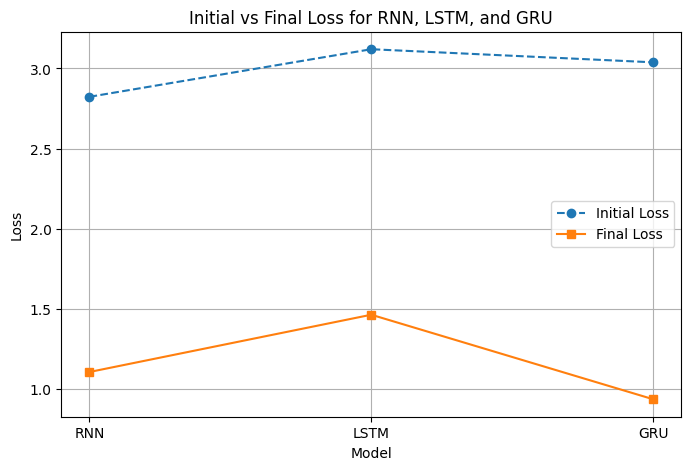

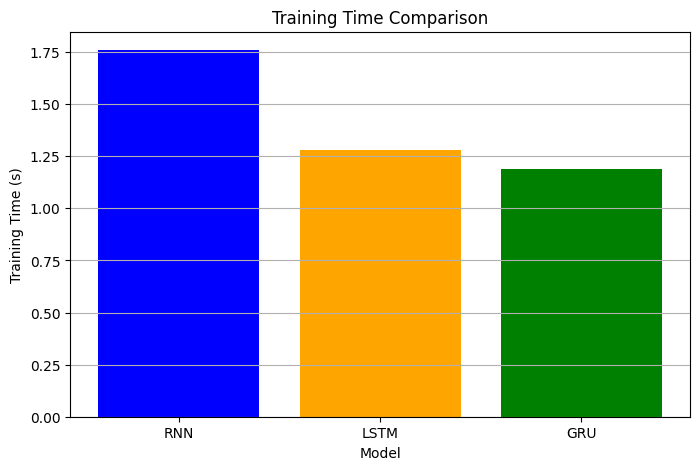

In [11]:
import matplotlib.pyplot as plt


models = ['RNN', 'LSTM', 'GRU']
initial_loss = [2.8234, 3.1200, 3.0384]
final_loss = [1.1080, 1.4650, 0.9383]
training_time = [1.76, 1.28, 1.19]

def plot_loss_reduction():
    plt.figure(figsize=(8, 5))
    plt.plot(models, initial_loss, marker='o', linestyle='--', label='Initial Loss')
    plt.plot(models, final_loss, marker='s', linestyle='-', label='Final Loss')
    plt.xlabel("Model")
    plt.ylabel("Loss")
    plt.title("Initial vs Final Loss for RNN, LSTM, and GRU")
    plt.legend()
    plt.grid()
    plt.show()

def plot_training_time():
    plt.figure(figsize=(8, 5))
    plt.bar(models, training_time, color=['blue', 'orange', 'green'])
    plt.xlabel("Model")
    plt.ylabel("Training Time (s)")
    plt.title("Training Time Comparison")
    plt.grid(axis='y')
    plt.show()


plot_loss_reduction()
plot_training_time()